# Deterministic optimisation (using the analytical queueing model)



We would like to establish whether we can use the IPOPT solver in Pyomo to solve optimisation formulations where the objective value is evaluated using the analytical queueing model. 

As a reminder - the M(t)/M/s(t) queueing model (details in the queueing_model.py script) takes as an input a vector of annual build rates for housing and shelter. Each annual build rate can be continuous-valued (i.e. there is now no rounding involved in the build rates). When analysing the dynamics of the queue, the code iterates through small time increments and does the following: 

* calculates the number of fully built houses/shelters and computes the probability distribution for a state space defined as the number of people in the system. This involves calculating the number of occupied houses using min(number of people in system, number of housing units available)
* based on this, then calculates the number unshelterd/sheltered/housed. This involves several max/min functions. 

In order to simplify the code, we remove all max() and min() functions. We do this as follows: 

* Where the number of busy servers (houses) is capped (using a min function) by the number of people in the system, we remove the cap, meaning even when there are unoccupied houses, the service rate at housing is equal to the service rate as if they were all occupied. This is clearly not correct, but we do this as a first step in order to check whether we can make the optimisation work without the min function
* We only calculate the expected number of people in the system, not the number unsheltered or sheltered, to remove the max and min functions associated with calculating the latter. 

We now analyse a somewhat trivial, artificial problem in order to test the IPOPT solver in Pyomo, where the objective function is evaluated by modelling the queue dynamics. 

#### A trivial problem

We allow up to $50$ housing units to be built in the first year (i.e. $0 <= h_1  <= 50$). We ensure that no shelter is built beyond the initial capacity, and no housing is built after year $1$. This is therefore a one dimensional problem. 

To start with a trivial problem we set up the following objective function: 

$y(h_1) = (h_1-25)^2$

The chart below illustrates how this function behaves within the feasible region for $h_1$

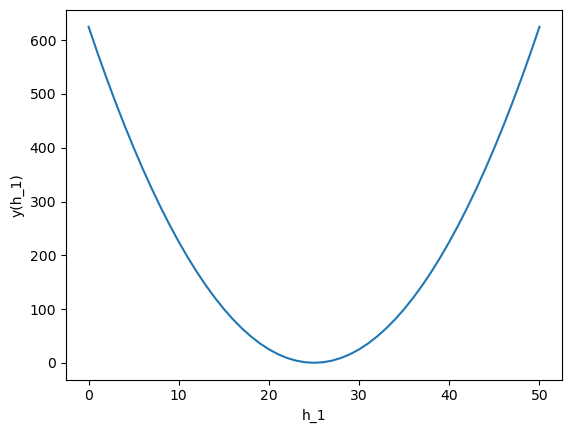

In [1]:
import matplotlib.pyplot as plt
X = [i for i in range(51)]
out = [(x-25)**2 for x in X]
fig, ax = plt.subplots()
ax.plot(X,out)
ax.set(xlabel='h_1', ylabel='y(h_1)')
plt.show()

We add code to the queueing model to record the function above when the model is analysed. We now use IPOPT within Pyomo to find the optimal solution. 

In [2]:
# imports
import deterministic_optimisation as do

# Set data for system behaviour
data = {'initial_capacity' : {'housing':40, 'shelter':15},
        'initial_demand' : 120, # initial number of people in system
        'service_mean' : {'housing': 4.0, 'shelter': 0.0}, # in years
        'arrival_rates' : [60.0]*5 + [30.0]*5,
        'budget' : 50, # in dollars
        'costs_accomm' : {'housing' : 1, 'shelter' : 1}, # cost in dollars per unit
        'baseline_build' : 0} # how many housing units and shelter units we must build at least each year

# Set modeliing options
modeling_options = {'horizon_model' : 5, # in years
                    'horizon_decision' : 5, # in years
                    'timestep' : 1/365, # in years
                    'model' : do.AnalyticalQueueModel}

q_model_options = {'bigM' : 500, 
                   'max_in_system' : 500}

# Set up problem and solve
problem = do.Phi6(data, modeling_options, 'phi6', q_model_options)
problem.solve('ipopt')

------- Optimal solution -------
Number of housing units to build annually: [25.0, 0.0, 0.0, 0.0, 0.0]
Number of shelter units to build annually: [0.0, 0.0, 0.0, 0.0, 0.0]
Total budget: 50
Number of housing/shelter units which must be built annually: 0
Surplus budget: 50
Proportion of surplus budget spent on housing: 50%: 25.0 extra houses.
Proportion of surplus budget spent on shelter: 0%: 0.0 extra shelters.
Optimal objective val: 0.0


The above shows that Pyomo is successfully able to interogate the analyical queueing model, extract an objective value based on the number of houses build in year 1 of the model run, and successfully optimise based on this objective function. **NOTE**: even though there is no information about the queue dynamics in the objetive function, to evaluate the objective function, one must still run the queue.model_dynamics() function. 

#### A more difficult problem

This is promising, but the objective function has not used information from the dynamics of the queue. We now propose a quadratic objective function that uses some information from the dynamics of the queue. We suggest the following objective function: 

$y(h_1) = h_1^2 + c \hspace{0.1cm} E[n_T(h_1)]^2$

where $E[n_T(h_1)]$ is the expected number of people in the system at the end of the modelling horizon, given a house building rate in year one of $h_1$ and $c$ is a constant of proportionality. 

The chart below illustrates how this function behaves within the feasible region for $h_1$ for $c = 0.1$. 

In [3]:
import queueing_model as qm
out = []
for i in range(51):
    solution = {'housing':[i,0,0,0,0],'shelter':[0,0,0,0,0]}
    model = qm.queue(data['arrival_rates'], data['service_mean'], data['initial_capacity'], solution, data['initial_demand'], q_model_options['max_in_system'])
    model.model_dynamics(modeling_options['horizon_model'],modeling_options['timestep']*365)
    out.append(model.h_2 + 0.1 * model.num_sys_2)

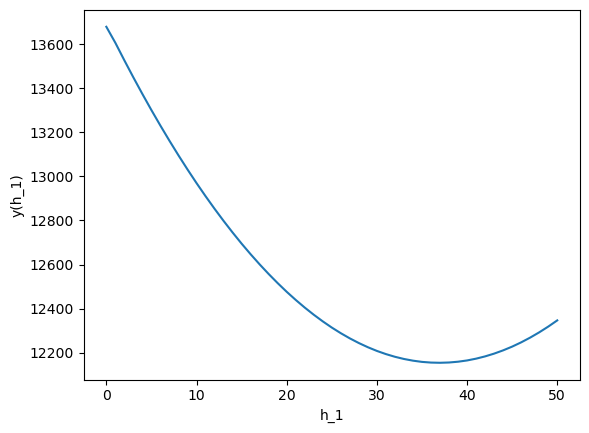

In [4]:
x = [i for i in range(51)]
fig, ax = plt.subplots()
ax.plot(x,out)
ax.set(xlabel='h_1', ylabel='y(h_1)')
plt.show()

With a clear interior point optimal solution, we might expect the IPOPT solver in Pyomo to find this optimal solution. However, the following code was left to run for some time without a solution being found. 

In [ ]:
# Set up problem and solve
import time
tic = time.perf_counter()
problem = do.Phi7(data, modeling_options, 'phi7', q_model_options)
problem.solve('ipopt')
toc = time.perf_counter()
print('Solved in ' + str(toc-tic) + ' seconds.')

It is currently unknown as to why Pyomo does not manage to solve this problem. The feasible region is continuous and the objective function is a smooth function within this feasible region, with a clear minimum. When the code in the above cell is interrupted (after running unsuccesfully for several hours) it appearted to be stuck in 'presolve' routine. A better understanding of the nuts and bolts of IPOPT in Pyomo may be required to get to the bottom of this. 

#### Re-introducing the min function

We would like to reintroduce the min function so that for each point in time, for each state in the state space, we have: 

$\text{number of occupied houses} = min(\text{number of people in the system}, \text{number of houses available})$

We cannot simply add this min function into the appropriate place in the model_dynamics() function, because this is adds non-linearities which Pyomo is not able to deal with. We propose here (and include in the determinsitic_optimisation.py script) a bigM formulation to solve this problem. 

Below is a generic optimisation formulation with a total budget constraint and a baseline build constraint. For simplicity we suggest an objective function which is only related to the number of people in the system (not the number sheltered/unsheltered/housed as this adds more max/min functions). 

**Initial formulation**

Let $T \in Z^{+}$ be a fixed horizon over which to model queue behaviour and to make building decisions.

Let vectors $\boldsymbol{h} = \{h_t \hspace{0.2cm} \forall t \in {1,...,T}\}$ and $\boldsymbol{s} = \{s_t \hspace{0.2cm} \forall t \in {1,...,T}\}$ denote annual house and shelter building rates, respectively. For simplicity we say that housing/shelter building rates are constant within each year. We can therefore consider $h(t) = \boldsymbol{h}$ and $s(t) = \boldsymbol{s}$ to be step functions. 

Let $c_{h} = 1$ be the cost of increasing $h_t$ by one, for any $t$. 

Let $c_{s}$ be the cost of increasing $s_t$ by one, for any $t$.

Let $C$ be a total budget for building housing and shelter

Let $B$ be a baseline minimum annual house/shetler building rate

Let $y(\boldsymbol{h},\boldsymbol{s})$ be a deterministic objective function, evaluated using the analytical queueing model.

\begin{align*}
        & \Phi_0 = \min_{\boldsymbol{h},\boldsymbol{s}} \hspace{0.2cm} y(\boldsymbol{h},\boldsymbol{s}) \\
        & \hspace{0.7cm} \text{ s.t. } \sum_{t=1}^{T} c_{h}h_{t} + c_{s}s_{t} \leq C \\
        & \hspace{1.5cm} h_t, s_t \geq B \hspace{0.2cm} \forall t \in \{1, ..., T\}
\end{align*}

where the objective function is the average over time of the expected number of people in the system. 
\begin{align*}
  y(\boldsymbol{h},\boldsymbol{s}) = \frac{1}{T} \int_0^T \mathbb{E}[n(t; \boldsymbol{h},\boldsymbol{s})] dt
\end{align*}
where $n(t;\boldsymbol{h},\boldsymbol{s})$ the number of people in system at time $t$ given build rates $\boldsymbol{h}$ and $\boldsymbol{s}$

**BigM formulation**

In order to enforce the min function discussed above, while removing it from the queue model evaluation, we introduce the following notation. 

Let $N$ be the max number of people in the system allowed by the numerical integration (this defines the size of the state space).

Let $H(t;\boldsymbol{h})$ be the number of available houses at time $t$, given the house build rate function $\boldsymbol{h}$. 

Let $m_{n,t}$ be the number of occupied houses at time $t$ when there are $n$ people in the system. 

Let $\boldsymbol{m} = \{m_{n,t} \hspace{0.2cm} \forall t \in {1,...,T} \hspace{0.2cm} \forall n \in {1,...,N}\}$

Let $\boldsymbol{y} = \{y_{n,t} \hspace{0.2cm} \forall t \in {1,...,T} \hspace{0.2cm} \forall n \in {1,...,N}\}$ be a matrix of binary variables

Let $M > N$ be a large number - greater than the number of people in the system. 

Let $y(\boldsymbol{h},\boldsymbol{s},\boldsymbol{m},\boldsymbol{y})$ be a deterministic objective function, evaluated using the analytical queueing model, *without* directly computing the number of occupied houses

The following optimisation formulation should now optimise the objective function while enforcing the appropriate minimisation. 

\begin{align*}
        & \bar{\Phi_0} = \min_{\boldsymbol{h},\boldsymbol{s},\boldsymbol{m},\boldsymbol{y}} \hspace{0.2cm} y(\boldsymbol{h},\boldsymbol{s},\boldsymbol{m},\boldsymbol{y}) \\
        & \hspace{0.7cm} \text{ s.t. } \sum_{t=1}^{T} c_{h}h_{t} + c_{s}s_{t} \leq C \\
        & \hspace{1.5cm} h_t, s_t \geq B \hspace{4cm} \forall t \in \{1, ..., T\} \\
        & \hspace{1.5cm} m_{n,t} \leq n \hspace{4cm} \forall t \in {1,...,T} \hspace{0.2cm} \forall n \in {1,...,N} \\
        & \hspace{1.5cm} m_{n,t} \leq H \hspace{4cm} \forall t \in {1,...,T} \hspace{0.2cm} \forall n \in {1,...,N} \\
        & \hspace{1.5cm} m_{n,t} \geq n - M(1-y_{n,t}) \hspace{1.5cm} \forall t \in {1,...,T} \hspace{0.2cm} \forall n \in {1,...,N} \\
        & \hspace{1.5cm} m_{n,t} \geq H - My_{nt} \hspace{2.5cm} \forall t \in {1,...,T} \hspace{0.2cm} \forall n \in {1,...,N} \\
        & \hspace{1.5cm} y_{n,t} \in \{0,1\} \hspace{3.5cm} \forall t \in {1,...,T} \hspace{0.2cm} \forall n \in {1,...,N}
\end{align*}

The above formulation can now be added to any optimisation problem in the deterministic optimisation script using the add_queue_model_constraints() function. It should be noted that the above adds many more constraints to the problem. A similar addition of constraints would be needed to enforce further maxima/minima associated with calculating the number of unsheltered/sheltered/housed at a given point in time. This has not been tested yet in the DO framework, as we still remain to be able to solve more simple formulations (as discussed earlier in this notebook). However, one technical hurdle to overcome will relate to how to refer to the $m_{n,t}$ variables when modeling the queue dynamics. 